In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import h5py
import seaborn as sns
from scipy.special import logit
from scipy.special import expit
from scipy.interpolate import RegularGridInterpolator
from pylab import rcParams
import sys
import torch
import scipy
import corner
import copy
from copy import deepcopy

import sys
sys.path.append('../')
from populations.bbh_models import read_hdf5
from populations.bbh_models import get_models
from populations.Flowsclass_dev import FlowModel
from populations.utils.bounded_Nd_kde import Bounded_Nd_kde

In [48]:
#flags/inputs:
param = ['mchirp','q', 'chieff', 'z']
no_params = len(param)
channel_label = 'SMT'

channel_ids = {'CE':0, 'CHE':1,'GC':2,'NSC':3, 'SMT':4}
channel_id = channel_ids[channel_label] #will be 0, 1, 2, 3, or 4
chi_b = [0.0,0.1,0.2,0.5]
alpha_CE = [0.2,0.5,1.0,2.,5.]
channel_samples = [4e6,864124,896611,582961, 4e6]
no_binaries = int(channel_samples[channel_id])
batch_size = 10000
total_hps=20

models_path ='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
#models_path ='/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/testing_notebooks/flow_samples.hdf5'
popsynth_outputs = read_hdf5(models_path, channel_label) # read all data from hdf5 file

models_dict = dict.fromkeys(popsynth_outputs.keys())
weights_dict = dict.fromkeys(popsynth_outputs.keys())


for key in popsynth_outputs.keys():
    models_dict[key] = popsynth_outputs[key][param]
    weights_dict[key]= popsynth_outputs[key]['weight']


In [49]:
#check that these distributions are the same between the whole (transformed distribution), batch, and the same for validation data
#no_trans, no_neurons, training_inputs, cond_inputs,no_binaries, batch_size, total_hps, RNVP=True, num_bins=4, device="cpu"):
flow = FlowModel(channel_label, popsynth_outputs, param, no_bins=4)
weighted_flow = FlowModel(channel_label, popsynth_outputs, param, no_bins=4)
model_names, KDE_models = get_models(models_path, [channel_label], param, use_flows=False, spin_distr=None, normalize=False, detectable=False)
#_, KDE_models_detectable = get_models(models_path, [channel_label], param, use_flows=False, spin_distr=None, sensitivity='midhighlatelow_network', normalize=False, detectable=True)


100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


In [50]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [51]:
weighted_flow.load_model('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_150124_extralong/flow_models/', channel_label)
#weighted_flow.load_model('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_011223/Flows_011223/flow_models_correctnonCEq/', channel_label)

In [18]:
submodels_dict

{0: {0: 'chi00', 1: 'chi01', 2: 'chi02', 3: 'chi05'}}

## Cosmo weighted Distributions - CE

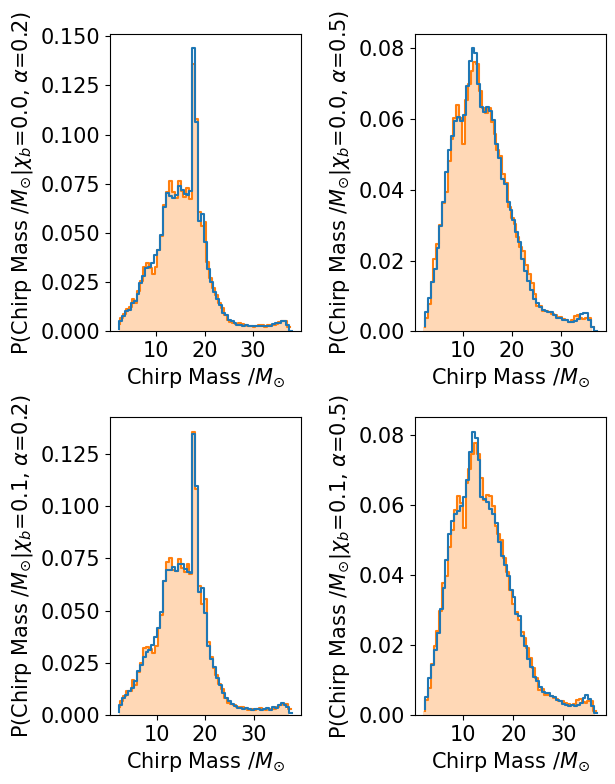

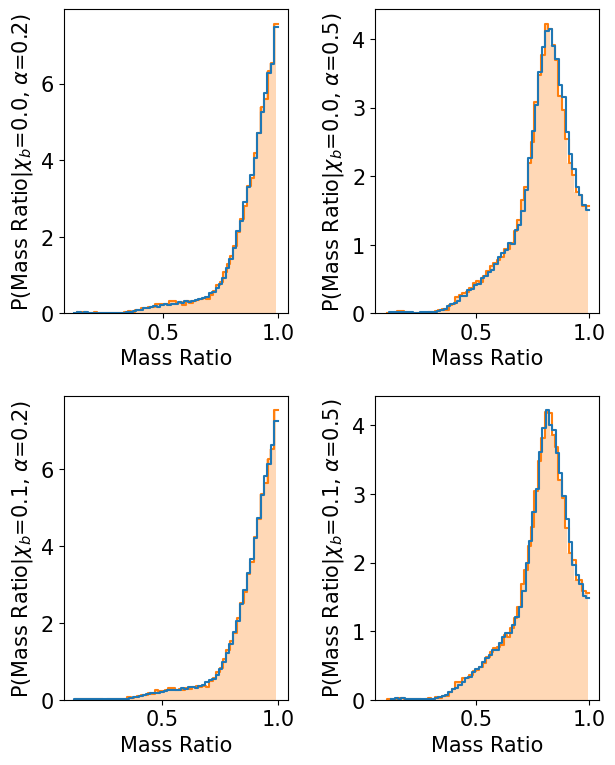

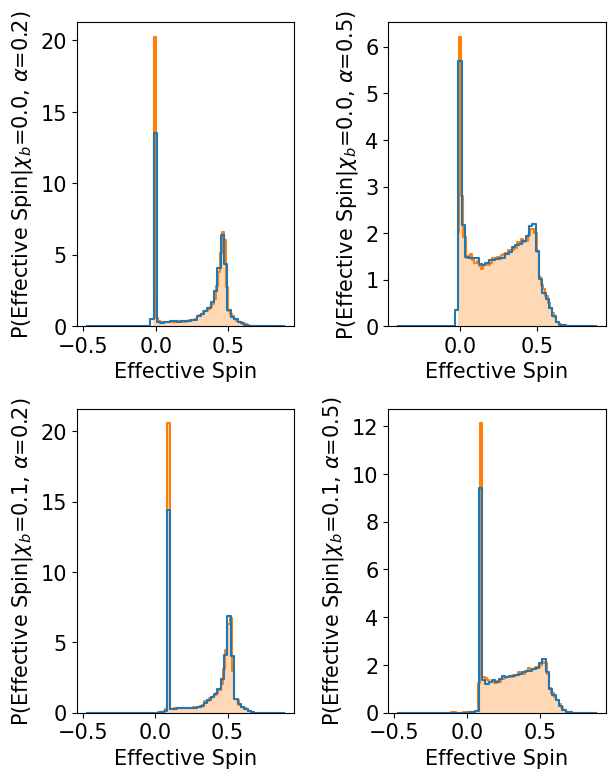

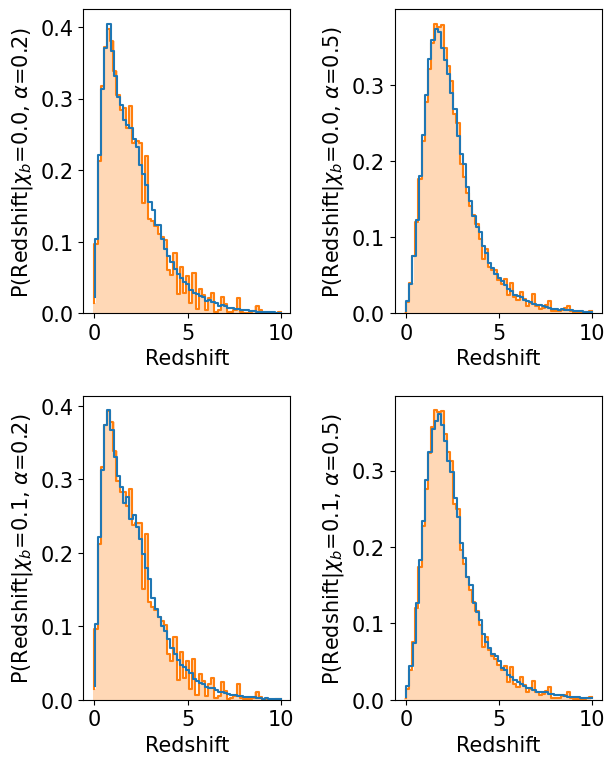

In [23]:
plt.rcParams["figure.figsize"] = (6.5,8)
plt.rcParams.update({'font.size': 15})
no_samples = 100000
no_bins = 60

fig_mchirp, ax_m = plt.subplots(2,2)
fig_q, ax_q = plt.subplots(2,2)
fig_c, ax_c = plt.subplots(2,2)
fig_z, ax_z = plt.subplots(2,2)

param_label = ['Chirp Mass /$M_{\odot}$','Mass Ratio', 'Effective Spin', 'Redshift']

chi_b = [0.,0.1]
alpha_CE = [0.2,0.5]

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        flow_samples_stack = weighted_flow.flow.sample(np.array([xb,a]), no_samples)
        flow_mchirp = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
        flow_q = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
        flow_chieff = np.tanh(flow_samples_stack[:,2])
        flow_z = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

        mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

        kde_samples = KDE_models['CE'][submodels_dict[0][chi_b_id]][submodels_dict[1][alpha_id]].sample(no_samples)

        for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
            flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
            kde_distr, bin_edges_KDE = np.histogram(kde_samples[:,i], bins=no_bins, density=True)
            known_distr, bin_edges_known =np.histogram(models_dict[(chi_b_id,alpha_id)][:][param[i]], bins=no_bins, density=True, weights=weights_dict[(chi_b_id,alpha_id)][:])
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
            #ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_KDE[0],bin_edges_KDE[-1],no_bins),kde_distr,label='KDE', color='purple')
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying', zorder=-200)
            ax[chi_b_id,alpha_id].hist(models_dict[(chi_b_id,alpha_id)][:][param[i]], align='left', bins=no_bins, density=True, zorder=-200, alpha=0.3, color='tab:orange', weights=weights_dict[(chi_b_id,alpha_id)][:])
            ax[chi_b_id,alpha_id].set_xlabel(fr'{param_label[i]}')
            ax[chi_b_id,alpha_id].set_ylabel(fr'P({param_label[i]}|$\chi_b$={xb}, $\alpha$={a})')
            #ax[chi_b_id,alpha_id].set_yscale('log')
            #ax[chi_b_id,alpha_id].legend()
            fig_mchirp.tight_layout(pad=1.3)
            fig_c.tight_layout(pad=1.3)
            fig_q.tight_layout(pad=1.3)
            fig_z.tight_layout(pad=1.3)

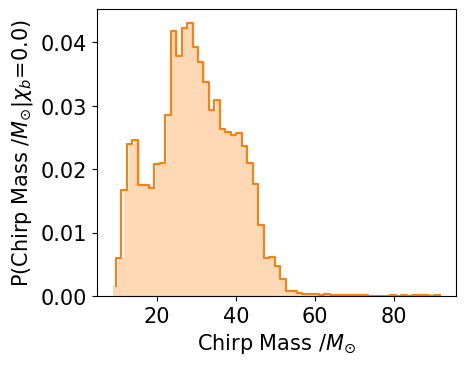

In [36]:
plt.rcParams["figure.figsize"] = (5,4)
plt.rcParams.update({'font.size': 15})
no_samples = 100000
no_bins = 60

fig_mchirp, ax_m = plt.subplots(1)

param_label = ['Chirp Mass /$M_{\odot}$','Mass Ratio', 'Effective Spin', 'Redshift']

chi_b = [0.]

for chi_b_id, xb in enumerate(chi_b):

    kde_samples = KDE_models['NSC'][submodels_dict[0][chi_b_id]].sample(no_samples)
    for i, ax in enumerate([ax_m]):
        kde_distr, bin_edges_KDE = np.histogram(kde_samples[:,i], bins=no_bins, density=True)
        known_distr, bin_edges_known =np.histogram(models_dict[(chi_b_id)][:][param[i]], bins=no_bins, density=True, weights=weights_dict[(chi_b_id)][:])
        #ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_KDE[0],bin_edges_KDE[-1],no_bins),kde_distr,label='KDE', color='purple')
        ax.step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying',color='tab:orange', zorder=-200)
        ax.hist(models_dict[(chi_b_id)][:][param[i]], align='left', bins=no_bins, density=True, zorder=-200, alpha=0.3, color='tab:orange', weights=weights_dict[(chi_b_id)][:])
        ax.set_xlabel(fr'{param_label[i]}')
        ax.set_ylabel(fr'P({param_label[i]}|$\chi_b$={xb})')
        #ax[chi_b_id,alpha_id].set_yscale('log')
        #ax[chi_b_id,alpha_id].legend()
        fig_mchirp.tight_layout(pad=1.3)

## Corner Plots for 1 subpop

In [7]:
param_label = ['Chirp Mass /$M_{\odot}$','Mass Ratio', 'Effective Spin', 'Redshift']

corner_kwargs = dict(
    bins=64,
    smooth=0.9,
    color="royalblue",
    #quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=False,
    hist_kwargs=dict(density=True),
    labels=param_label,
    axes_scale='log',
    zorder=1000,
)

In [8]:
corner_kwargs_kde = dict(
    bins=64,
    smooth=0.9,
    color="navy",
    #quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=False,
    hist_kwargs=dict(density=True),
    labels=param_label,
    axes_scale='log',
)

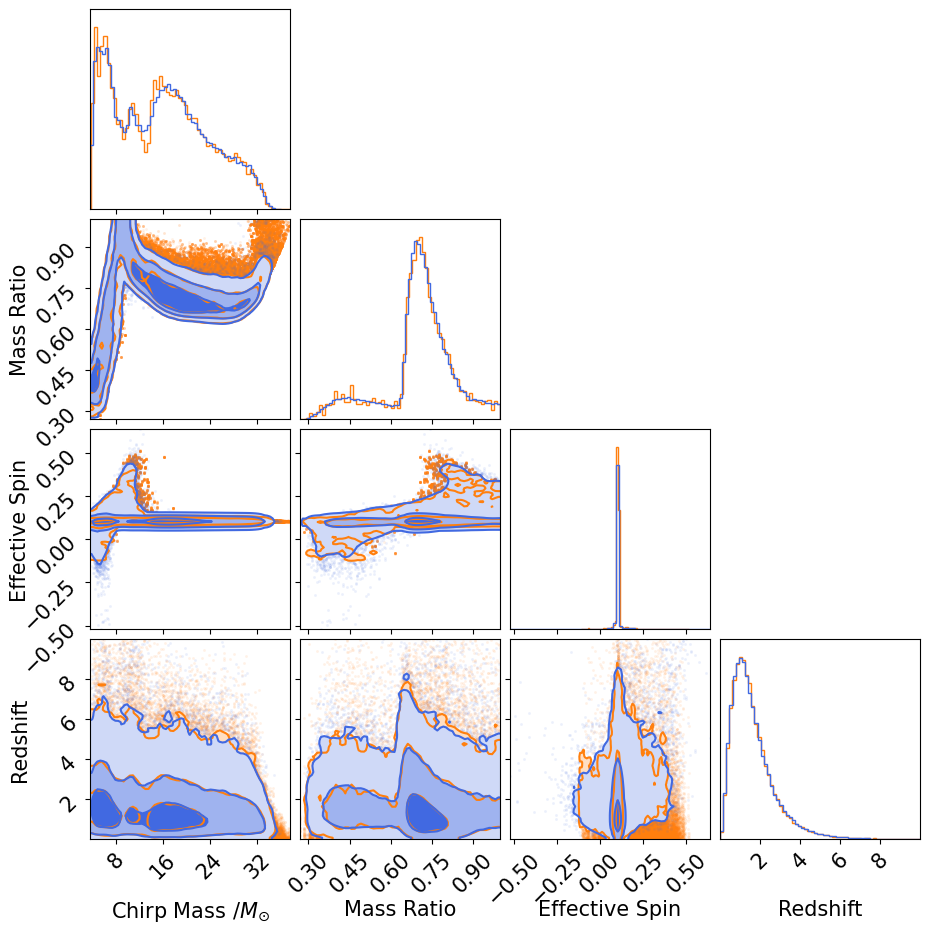

In [52]:
#sample flow
no_samples=100000
hyperparam_idxs = (1)
kwargs = deepcopy(corner_kwargs)
kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"
plt.rcParams.update({'font.size': 15})

flow_samples_stack = weighted_flow.flow.sample(np.array([0.1]),no_samples)
flow_samples_stack[:,0] = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_samples_stack[:,1] = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
flow_samples_stack[:,3] = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

fig =corner.corner(models_dict[hyperparam_idxs],  weights=weights_dict[hyperparam_idxs][:], **kwargs)
fig = corner.corner(flow_samples_stack.numpy(), fig=fig, **corner_kwargs)

## Corner plot CE

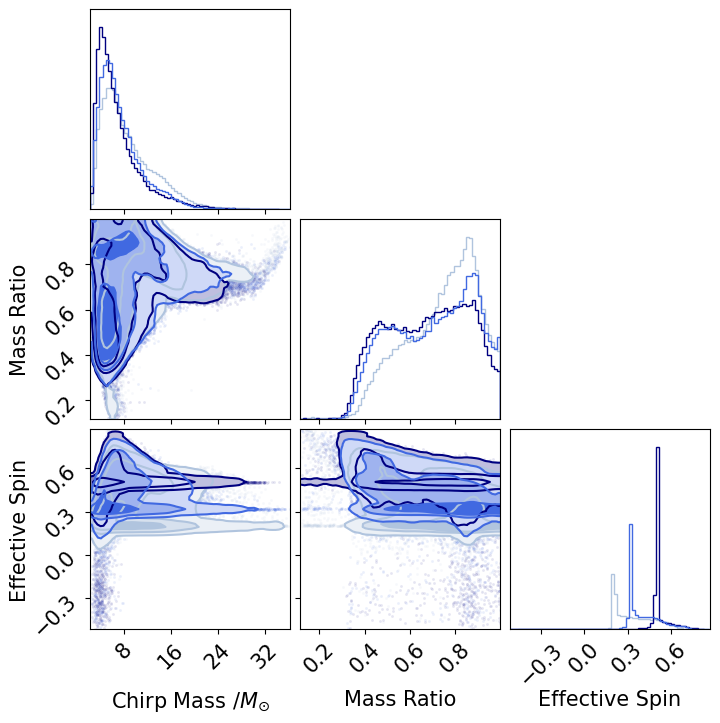

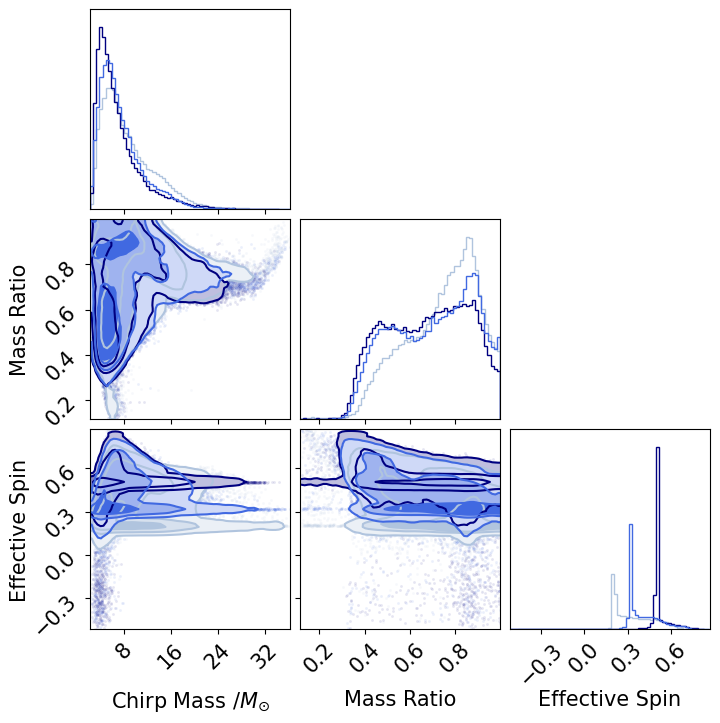

In [53]:
#sample flow
no_samples=100000
hyperparam_idxs = (0,2)
kwargs = deepcopy(corner_kwargs_kde)
kwargs["color"] = "lightsteelblue"
kwargs["hist_kwargs"]["color"] = "lightsteelblue"
param_label = ['Chirp Mass /$M_{\odot}$','Mass Ratio', 'Effective Spin', 'Redshift']


flow_samples_stack = weighted_flow.flow.sample(np.array([0.2,2.]),no_samples)
flow_samples_stack[:,0] = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_samples_stack[:,1] = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
flow_samples_stack[:,3] = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])
fig = corner.corner(flow_samples_stack.numpy()[:,:3], **kwargs)

flow_samples_stack = weighted_flow.flow.sample(np.array([0.5,5.]),no_samples)
flow_samples_stack[:,0] = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_samples_stack[:,1] = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
flow_samples_stack[:,3] = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])
corner.corner(flow_samples_stack.numpy()[:,:3], fig=fig, **corner_kwargs_kde)

flow_samples_stack = weighted_flow.flow.sample(np.array([0.31,3.55]),no_samples)
flow_samples_stack[:,0] = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_samples_stack[:,1] = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
flow_samples_stack[:,3] = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])
corner.corner(flow_samples_stack.numpy()[:,:3], fig=fig, **corner_kwargs)


## Corner plot CE test population

In [9]:
weighted_flow.load_model('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_070324_CEtestremoved/flow_models/', channel_label)


In [10]:
param_label = ['Chirp Mass /$M_{\odot}$','Mass Ratio', 'Effective Spin', 'Redshift']

corner_kwargs = dict(
    bins=64,
    smooth=0.9,
    color="tab:blue",
    #quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=False,
    hist_kwargs=dict(density=True),
    labels=param_label,
    axes_scale='log',
    zorder=1000,
)

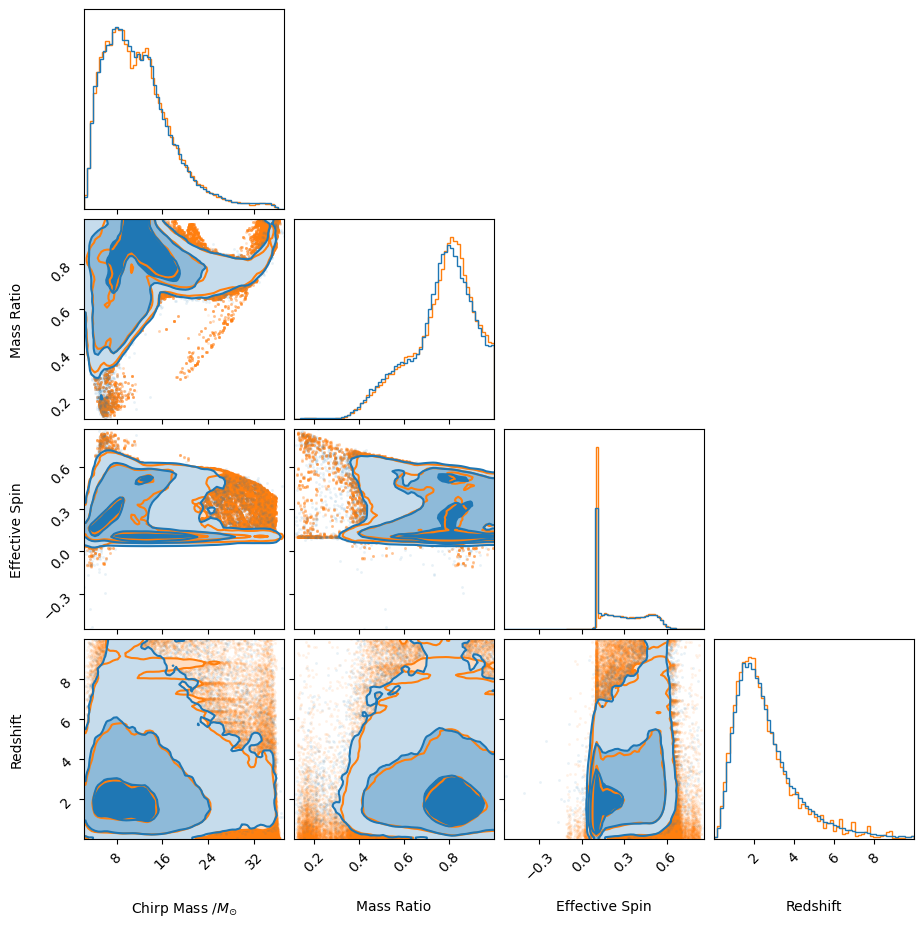

In [11]:
#sample flow
no_samples=100000
hyperparam_idxs = (1,2)
kwargs = deepcopy(corner_kwargs)
kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"

flow_samples_stack = weighted_flow.flow.sample(np.array([0.1,1.]),no_samples)
flow_samples_stack[:,0] = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_samples_stack[:,1] = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
flow_samples_stack[:,3] = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])


fig =corner.corner(models_dict[hyperparam_idxs],  weights=weights_dict[hyperparam_idxs][:], **kwargs)
fig = corner.corner(flow_samples_stack.numpy(), fig=fig, **corner_kwargs)

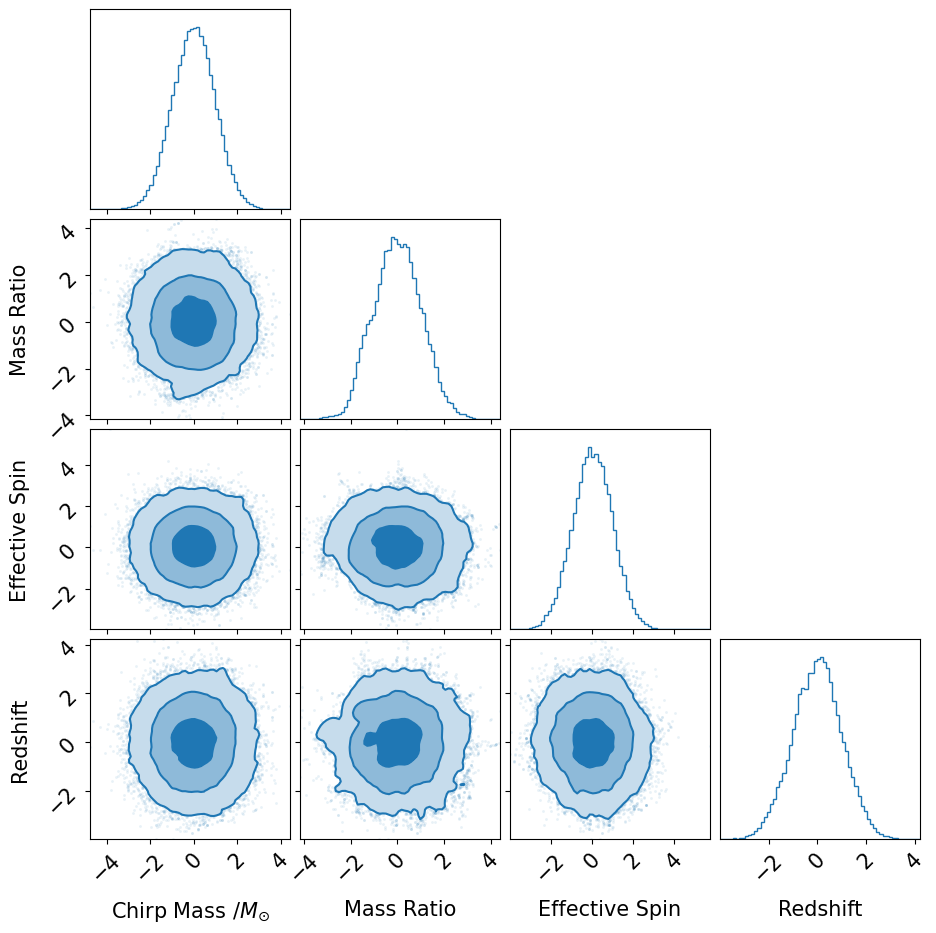

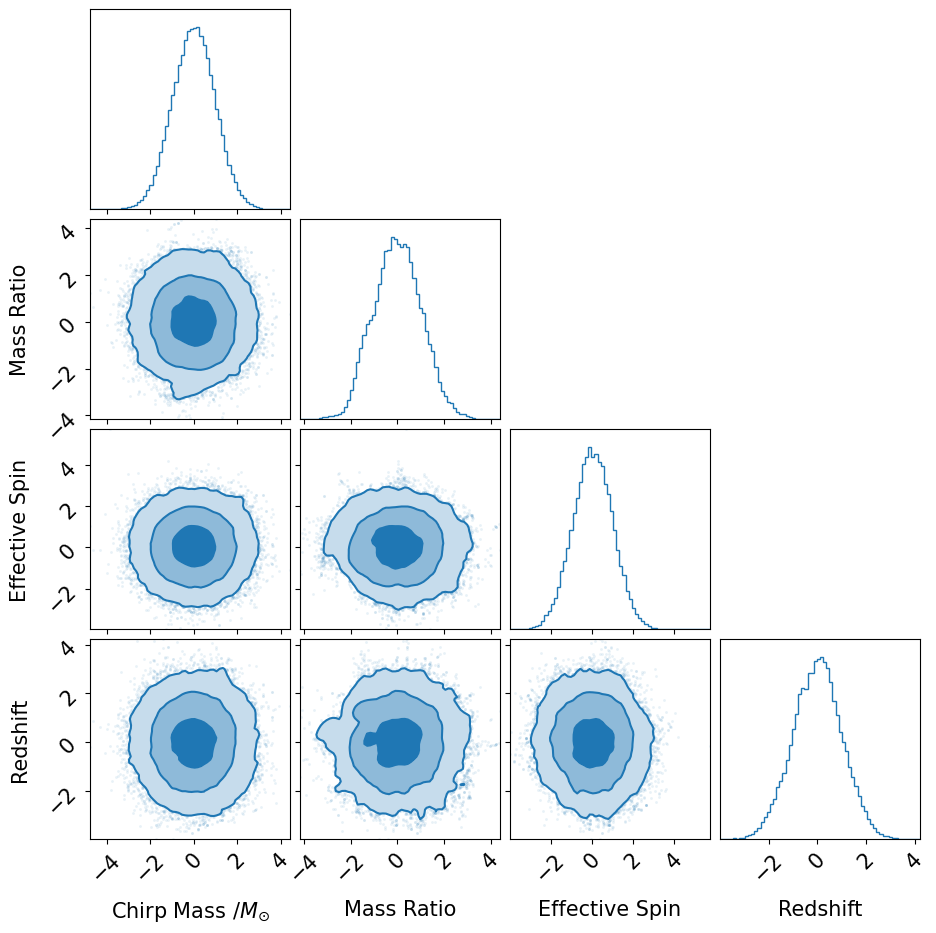

In [36]:
#CE, returns samples in the latent space of the flow

plt.rcParams.update({'font.size': 15})
cond_id = [0,0]
training_samps=np.reshape(np.array(models_dict[cond_id[0],cond_id[1]]), (-1,1,4))
latent_samps = weighted_flow.get_latent_samps(training_samps[:no_samples,:], [chi_b[cond_id[0]], alpha_CE[cond_id[1]]]).detach().numpy()


random_samples = np.random.choice(np.shape(training_samps)[0], size=(no_samples), p=weights_dict[cond_id[0],cond_id[1]]/np.sum(weights_dict[cond_id[0],cond_id[1]]))
training_samps = np.reshape(np.array(models_dict[cond_id[0],cond_id[1]])[random_samples], (-1,1,4))

weighted_latent_samps = weighted_flow.get_latent_samps(training_samps, [chi_b[cond_id[0]], alpha_CE[cond_id[1]]]).detach().numpy()
corner.corner(weighted_latent_samps, **corner_kwargs)



In [12]:
from scipy.stats import entropy
from scipy.stats import gaussian_kde

In [23]:
def KL_evaluate(flow_samps, underlying_samps, underlying_weights):
        def pdf_evaluate(samples, weights):
            density = gaussian_kde(samples, weights=weights)
            kde_points = density.pdf(np.linspace(-50, 500, 1000))
            return np.array(kde_points)
        pdf_samples = pdf_evaluate(flow_samps, np.ones(len(flow_samples_stack[0].shape)))
        underlying_pdf = pdf_evaluate(underlying_samps, underlying_weights)
        return pdf_samples, entropy(pdf_samples, underlying_pdf)

In [24]:
KL_evaluate(flow_samples_stack, models_dict[hyperparam_idxs], weights_dict[hyperparam_idxs][:])

ValueError: `weights` input should be of length n

In [25]:
np.ones(flow_samples_stack.shape[0]).shape

(100000,)

In [26]:
flow_samples_stack.shape

torch.Size([100000, 4])